In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
results = pd.read_csv("../RESULT/RESULTADOS-stemmer.csv", sep=";", converters={"DocInfos": pd.eval})
results.head()

,QueryNumber,DocInfos
0,1,"[1, 437, 0.27588934462955456]"
1,1,"[2, 498, 0.20844373959940954]"
2,1,"[3, 484, 0.18440699663023122]"
3,1,"[4, 754, 0.17310807431022798]"
4,1,"[5, 957, 0.16879740146000236]"


In [3]:
def get_expected_docs(expected_file_df):
    query_docs = {}
    query_numbers = list(expected_file_df["QueryNumber"].unique())
    for query_number in query_numbers:
        docs = list(expected_file_df.loc[expected_file_df["QueryNumber"] == query_number]["DocNumber"])
        query_docs[query_number] = docs
    return query_docs

def get_results_docs(results_file_df):
    results_docs = {}
    query_numbers = list(results_file_df["QueryNumber"].unique())
    for query_number in query_numbers:
        docs = []
        query_results = list(results_file_df.loc[results_file_df["QueryNumber"] == query_number]["DocInfos"])
        for single_result in query_results:
            doc_number = int(single_result[1])
            docs.append(doc_number)
        results_docs[query_number] = docs
    return results_docs

In [4]:
expected = pd.read_csv("../RESULT/ESPERADOS.csv", sep=";")
expected.head()

,QueryNumber,DocNumber,DocVotes
0,1,139,4
1,1,151,4
2,1,166,1
3,1,311,1
4,1,370,2


In [5]:
ex_docs = get_expected_docs(expected)
res_docs = get_results_docs(results)
ex_docs[1][:10] # não ordenado
res_docs[1][:10] # ordenado

[437, 498, 484, 754, 957, 533, 827, 499, 925, 441]

In [6]:
def precision(list_correct, list_return):
    total_correct = 0
    for doc_number in list_return:
        if doc_number in list_correct:
            total_correct += 1
    total_return = len(list_return)
    return total_correct / total_return * 100

def recall(doc_number, list_docs):
    total_docs = len(list_docs)
    if doc_number in list_docs:
        return 1 / total_docs * 100
    return 0.0

def pr_curve(expected_docs, results_docs, query_number):
    correct_docs = expected_docs[query_number]
    returned_docs = results_docs[query_number]
    plot_table = pd.DataFrame([], columns=["DocNumber", "Recall", "Precision"])
    r = 0.0
    for index, doc_number in enumerate(returned_docs):
        if recall(doc_number, correct_docs) == 0.0:
            continue
        r += recall(doc_number, correct_docs)
        p = precision(correct_docs, returned_docs[:index+1])
        plot_table.loc[index] = [int(doc_number), r, p]
    return plot_table

In [7]:
pr_curve(ex_docs, res_docs, 90)

,DocNumber,Recall,Precision
0,7.0,3.571429,100.000000
1,177.0,7.142857,100.000000
2,451.0,10.714286,100.000000
3,884.0,14.285714,100.000000
4,260.0,17.857143,100.000000
5,912.0,21.428571,100.000000
6,1090.0,25.000000,100.000000
7,479.0,28.571429,100.000000
8,778.0,32.142857,100.000000
10,589.0,35.714286,90.909091


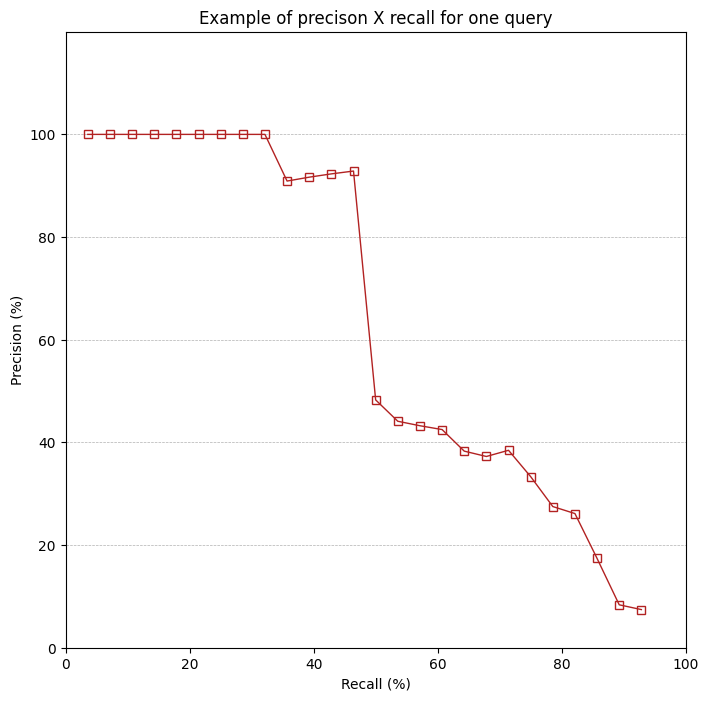

In [8]:
plt.figure(figsize=(8, 8))
plt.plot(pr_curve(ex_docs, res_docs, 90)["Recall"], pr_curve(ex_docs, res_docs, 90)["Precision"], 
         marker="s", markerfacecolor="none", ms=6, color="firebrick", linewidth=1)
plt.axis([0, 100, 0, 120])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)
plt.title("Example of precison X recall for one query")
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")
plt.yticks([0, 20, 40, 60, 80, 100])
plt.show()

In [9]:
def create_eleven_points_table(expected_docs, results_docs):
    table = pd.DataFrame([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], columns=["Recall"])
    query_numbers = list(expected_docs.keys())
    for query_number in query_numbers:
        eleven_points = pd.Series([], name=f"pQ{query_number}")
        curve = pr_curve(ex_docs, res_docs, query_number)
        for index, r in enumerate(range(0, 101, 10)):
            eleven_points[index] = curve.loc[curve["Recall"] > r]["Precision"].max()  
        table = pd.concat([table, eleven_points], axis=1)
    table.fillna(0, inplace=True)
    return table

eleven_points_df = create_eleven_points_table(ex_docs, res_docs)
eleven_points_df

,Recall,pQ1,pQ2,pQ3,pQ4,pQ5,pQ6,pQ7,pQ8,pQ9,...,pQ90,pQ91,pQ92,pQ94,pQ95,pQ96,pQ97,pQ98,pQ99,pQ100
0,0,31.818182,40.000000,100.000000,33.333333,100.000000,100.000000,100.000000,13.333333,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,10,31.818182,40.000000,38.461538,33.333333,59.259259,75.000000,50.000000,2.293578,28.571429,...,100.000000,38.372093,77.777778,83.333333,100.000000,50.000000,66.666667,100.000000,100.000000,100.000000
2,20,31.818182,40.000000,15.254237,16.666667,36.842105,27.777778,20.689655,2.293578,27.272727,...,100.000000,31.372549,71.794872,50.000000,100.000000,27.272727,50.000000,4.761905,100.000000,75.000000
3,30,26.829268,8.108108,14.772727,14.285714,34.677419,18.000000,9.090909,2.293578,19.047619,...,100.000000,31.372549,52.702703,33.333333,6.521739,22.222222,35.714286,3.546099,100.000000,22.222222
4,40,26.153846,8.108108,10.714286,14.285714,28.648649,15.384615,6.703911,2.293578,13.636364,...,92.857143,30.652174,25.000000,29.166667,1.731602,12.820513,35.714286,2.450980,100.000000,2.314815
5,50,23.376623,1.165501,7.213115,13.513514,0.000000,13.131313,4.292929,2.293578,13.636364,...,44.117647,29.980276,17.391304,27.058824,1.470588,5.833333,24.000000,2.450980,100.000000,2.140673
6,60,14.285714,1.165501,6.122449,9.090909,0.000000,8.333333,4.292929,2.293578,10.606061,...,42.500000,0.000000,14.446529,0.000000,1.145663,5.228758,10.714286,2.450980,1.438849,2.140673
7,70,5.797101,1.165501,4.718417,5.785124,0.000000,4.927536,3.056769,0.000000,10.000000,...,38.461538,0.000000,12.361111,0.000000,1.145663,1.453958,10.714286,2.335456,1.438849,2.044990
8,80,3.391813,0.000000,4.609475,3.305785,0.000000,3.846154,2.718007,0.000000,3.396226,...,26.136364,0.000000,0.000000,0.000000,0.000000,1.000000,10.714286,0.000000,0.914077,2.044990
9,90,0.000000,0.000000,4.362416,0.000000,0.000000,2.756892,0.000000,0.000000,0.000000,...,7.428571,0.000000,0.000000,0.000000,0.000000,0.000000,1.376721,0.000000,0.914077,2.044990


In [11]:
def add_mean_precision(eleven_points_df):
    pi = pd.Series([], name="pi")
    copy_11 = eleven_points_df.set_index(["Recall"])
    n_columns = len(copy_11.columns)
    for i in range(11):
        pi.loc[i] = copy_11.loc[i * 10].sum() / n_columns  
    eleven_points_df = pd.concat([eleven_points_df, pi], axis=1)
    return eleven_points_df

eleven_points_df = add_mean_precision(eleven_points_df)
eleven_points_df.to_csv("../AvaliacaoModeloRI/11pontos-stemmer-1.csv")
eleven_points_df

,Recall,pQ1,pQ2,pQ3,pQ4,pQ5,pQ6,pQ7,pQ8,pQ9,...,pQ92,pQ94,pQ95,pQ96,pQ97,pQ98,pQ99,pQ100,pi,pi
0,0,31.818182,40.000000,100.000000,33.333333,100.000000,100.000000,100.000000,13.333333,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,82.935328,82.935328
1,10,31.818182,40.000000,38.461538,33.333333,59.259259,75.000000,50.000000,2.293578,28.571429,...,77.777778,83.333333,100.000000,50.000000,66.666667,100.000000,100.000000,100.000000,60.219075,60.219075
2,20,31.818182,40.000000,15.254237,16.666667,36.842105,27.777778,20.689655,2.293578,27.272727,...,71.794872,50.000000,100.000000,27.272727,50.000000,4.761905,100.000000,75.000000,43.007512,43.007512
3,30,26.829268,8.108108,14.772727,14.285714,34.677419,18.000000,9.090909,2.293578,19.047619,...,52.702703,33.333333,6.521739,22.222222,35.714286,3.546099,100.000000,22.222222,33.072941,33.072941
4,40,26.153846,8.108108,10.714286,14.285714,28.648649,15.384615,6.703911,2.293578,13.636364,...,25.000000,29.166667,1.731602,12.820513,35.714286,2.450980,100.000000,2.314815,25.694572,25.694572
5,50,23.376623,1.165501,7.213115,13.513514,0.000000,13.131313,4.292929,2.293578,13.636364,...,17.391304,27.058824,1.470588,5.833333,24.000000,2.450980,100.000000,2.140673,17.881586,17.881586
6,60,14.285714,1.165501,6.122449,9.090909,0.000000,8.333333,4.292929,2.293578,10.606061,...,14.446529,0.000000,1.145663,5.228758,10.714286,2.450980,1.438849,2.140673,12.173999,12.173999
7,70,5.797101,1.165501,4.718417,5.785124,0.000000,4.927536,3.056769,0.000000,10.000000,...,12.361111,0.000000,1.145663,1.453958,10.714286,2.335456,1.438849,2.044990,8.502578,8.502578
8,80,3.391813,0.000000,4.609475,3.305785,0.000000,3.846154,2.718007,0.000000,3.396226,...,0.000000,0.000000,0.000000,1.000000,10.714286,0.000000,0.914077,2.044990,4.861676,4.861676
9,90,0.000000,0.000000,4.362416,0.000000,0.000000,2.756892,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.376721,0.000000,0.914077,2.044990,2.177977,2.177977


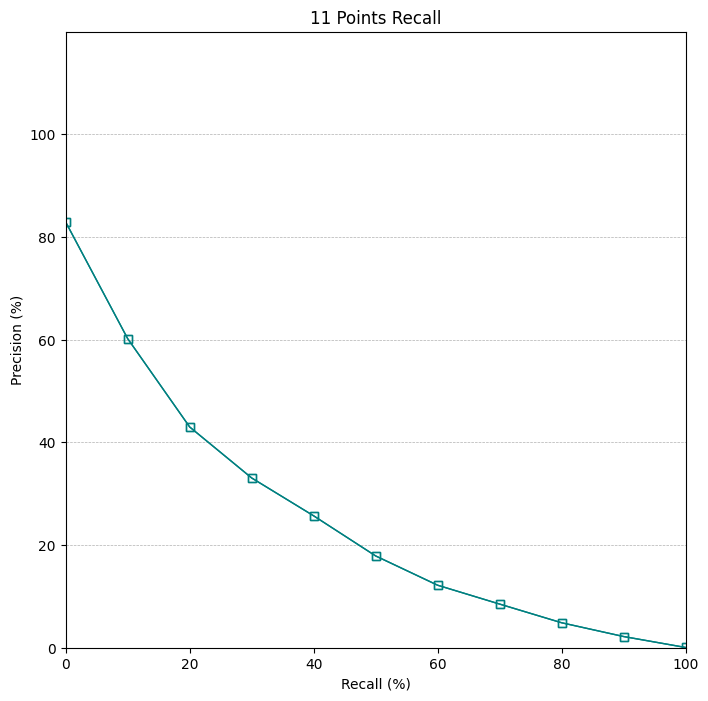

In [13]:
plt.figure(figsize=(8, 8))
plt.plot(eleven_points_df["Recall"], eleven_points_df["pi"], 
         marker="s", markerfacecolor="none", ms=6, color="teal", linewidth=1)
plt.axis([0, 100, 0, 120])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)
plt.title("11 Points Recall")
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")
plt.yticks([0, 20, 40, 60, 80, 100])
plt.savefig("../AvaliacaoModeloRI/11pontos-stemmer-1.png")
plt.show()

In [15]:
def query_recall(expected_docs, results_docs, query_number):
    relevant_docs = expected_docs[query_number]
    retrieved_docs = results_docs[query_number]
    relevant_retrieved = 0
    for doc_number in retrieved_docs:
        if doc_number in relevant_docs:
            relevant_retrieved += 1
    relevant_total = len(relevant_docs)
    return relevant_retrieved / relevant_total

def query_precision(expected_docs, results_docs, query_number):
    relevant_docs = expected_docs[query_number]
    retrieved_docs = results_docs[query_number]
    relevant_retrieved = 0
    for doc_number in retrieved_docs:
        if doc_number in relevant_docs:
            relevant_retrieved += 1
    retrieved_total = len(retrieved_docs)
    return relevant_retrieved / retrieved_total

r = query_recall(ex_docs, res_docs, 90)
p = query_precision(ex_docs, res_docs, 90)
print(f"Recall = {r}\nPrecision = {p}")

Recall = 0.9285714285714286
Precision = 0.028888888888888888


In [16]:
def f1_score(p, r):
    return (2*p*r) / (p+r)

def get_f1_table(expected_docs, results_docs):
    query_numbers = list(expected_docs.keys())
    f1_table = pd.DataFrame([], columns=["F1", "QueryNumber"])
    for index, query_number in enumerate(query_numbers):
        r = query_recall(expected_docs, results_docs, query_number)
        p = query_precision(expected_docs, results_docs, query_number)
        f1 = f1_score(p, r)
        f1_table.loc[index] = [f1, query_number]
    return f1_table

f1 = get_f1_table(ex_docs, res_docs)
f1.to_csv("../AvaliacaoModeloRI/f1-stemmer-3.csv")
f1.head()

,F1,QueryNumber
0,0.063806,1.0
1,0.016863,2.0
2,0.080868,3.0
3,0.061538,4.0
4,0.297521,5.0
